
--- Processing images: 'Dubai_2.jpg' (Ref) vs 'Dubai_1.jpg' (Test) ---
Loading previously trained model from continual_ae_model.pth
Starting training for /content/drive/MyDrive/pca_kmeans/Dubai_2.jpg with 10 epochs...


Training Epochs: 100%|██████████| 10/10 [03:51<00:00, 23.18s/it]


Final training loss for /content/drive/MyDrive/pca_kmeans/Dubai_2.jpg: 0.001372
Model state saved to continual_ae_model.pth


Processing patches: 100%|██████████| 49/49 [00:17<00:00,  2.78it/s]


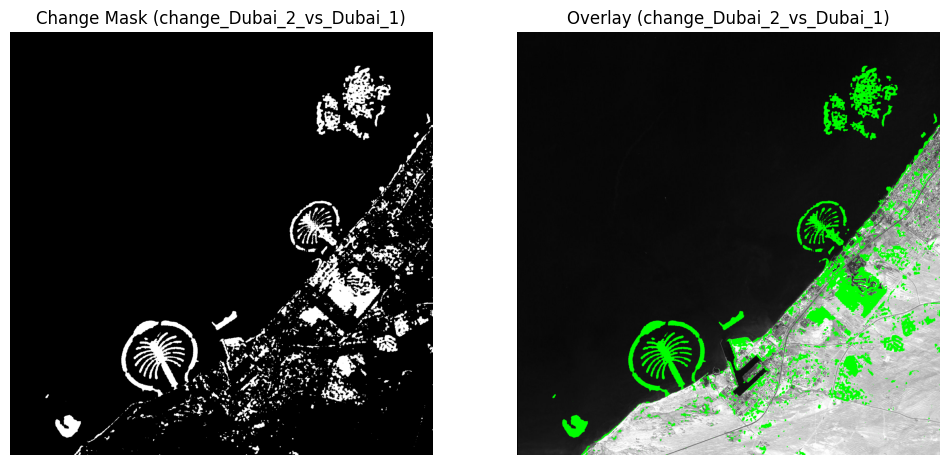

✅ Inference Done.

--- Process completed ---
To run with new images, simply modify the 'image_before' and 'image_after' variables at the top of the 'Main Execution Block' and re-run this cell.


In [7]:
# One-Shot Change Detection with Autoencoder (no dataset training)
import os
import cv2
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from skimage.filters import threshold_otsu
import matplotlib.pyplot as plt
from tqdm import tqdm

PATCH_SIZE = 256
MODEL_SAVE_PATH = "continual_ae_model.pth" # Define a consistent path for your model

# Autoencoder
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 64, 3, stride=1, padding=1), nn.ReLU(), nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 128, 3, stride=1, padding=1), nn.ReLU(), nn.MaxPool2d(2, 2),
            nn.Conv2d(128, 256, 3, stride=1, padding=1), nn.ReLU(), nn.MaxPool2d(2, 2)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 2, stride=2), nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 2, stride=2), nn.ReLU(),
            nn.ConvTranspose2d(64, 1, 2, stride=2), nn.Sigmoid()
        )

    def forward(self, x):
        return self.decoder(self.encoder(x))

# 🔧 Patch utilities
def image_to_patches(img):
    h, w = img.shape
    patches, coords = [], []
    for y in range(0, h, PATCH_SIZE):
        for x in range(0, w, PATCH_SIZE):
            patch = img[y:y+PATCH_SIZE, x:x+PATCH_SIZE]
            pad = np.zeros((PATCH_SIZE, PATCH_SIZE), dtype=img.dtype)
            pad[:patch.shape[0], :patch.shape[1]] = patch
            patches.append(pad)
            coords.append((y, x))
    return patches, coords, h, w

def patches_to_image(patches, coords, h, w):
    img = np.zeros((h, w), dtype=np.uint8)
    for patch, (y, x) in zip(patches, coords):
        h_end, w_end = min(y+PATCH_SIZE, h), min(x+PATCH_SIZE, w)
        img[y:h_end, x:w_end] = patch[:h_end - y, :w_end - x]
    return img

# Train on a single reference image (modified to save model)
def train_on_single_image(ref_image_path, model, device, epochs=20, save_path=None):
    model.train()
    img = cv2.imread(ref_image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        print(f"Error: Could not load image from {ref_image_path}. Please check the path.")
        return False # Indicate training failed
    patches, _, _, _ = image_to_patches(img)

    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    transform = transforms.ToTensor()

    print(f"Starting training for {ref_image_path} with {epochs} epochs...")
    for epoch in tqdm(range(epochs), desc="Training Epochs"): # Added tqdm for epochs
        total_loss = 0
        for patch in patches:
            patch_tensor = transform(patch).unsqueeze(0).to(device)
            optimizer.zero_grad()
            recon = model(patch_tensor)
            loss = F.mse_loss(recon, patch_tensor)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        # print(f"Epoch {epoch+1} Loss: {total_loss/len(patches):.6f}") # Moved print outside tqdm
    print(f"Final training loss for {ref_image_path}: {total_loss/len(patches):.6f}")

    if save_path:
        torch.save(model.state_dict(), save_path)
        print(f"Model state saved to {save_path}")
    return True # Indicate training succeeded

# Inference to detect change
def infer_change(ref_image_path, test_image_path, model, device, manual_thresh=None):
    model.eval()
    ref_img = cv2.imread(ref_image_path, cv2.IMREAD_GRAYSCALE)
    test_img = cv2.imread(test_image_path, cv2.IMREAD_GRAYSCALE)
    ref_img_rgb = cv2.imread(ref_image_path, cv2.IMREAD_COLOR)  # BGR format

    if ref_img is None or test_img is None or ref_img_rgb is None:
        print(f"Error: Could not load images for inference. Ref: {ref_image_path}, Test: {test_image_path}")
        return

    ref_patches, coords, h, w = image_to_patches(ref_img)
    test_patches, _, _, _ = image_to_patches(test_img)

    diff_patches = []
    with torch.no_grad():
        for r_patch, t_patch in tqdm(zip(ref_patches, test_patches), total=len(ref_patches), desc="Processing patches"):
            r_tensor = transforms.ToTensor()(r_patch).unsqueeze(0).to(device)
            t_tensor = transforms.ToTensor()(t_patch).unsqueeze(0).to(device)

            r_recon = model(r_tensor)
            t_recon = model(t_tensor)

            # Calculate difference. Using absolute difference for simple change.
            diff = torch.abs(r_recon - t_recon).squeeze().cpu().numpy()
            diff = (diff * 255).astype(np.uint8)

            if diff.size == 0:
                print("Warning: Empty diff patch encountered.")
                binary = np.zeros((PATCH_SIZE, PATCH_SIZE), dtype=np.uint8) # Ensure it's a valid patch
            else:
                if manual_thresh is not None:
                    th = manual_thresh
                else:
                    try:
                        th = threshold_otsu(diff)
                    except ValueError:
                        print("Warning: Otsu's thresholding failed for a patch, using default 128.")
                        th = 128

                binary = (diff > th).astype(np.uint8) * 255
            diff_patches.append(binary)

    binary_mask = patches_to_image(diff_patches, coords, h, w)
    overlay = ref_img_rgb.copy()
    overlay[binary_mask > 0] = [0, 255, 0] # Green color for change

    # Determine a relevant output file name
    ref_name = os.path.splitext(os.path.basename(ref_image_path))[0]
    test_name = os.path.splitext(os.path.basename(test_image_path))[0]
    output_prefix = f"change_{ref_name}_vs_{test_name}"

    cv2.imwrite(f"{output_prefix}_mask.png", binary_mask)
    cv2.imwrite(f"{output_prefix}_overlay.png", overlay)


    plt.figure(figsize=(12,6))
    plt.subplot(1,2,1)
    plt.imshow(binary_mask, cmap="gray")
    plt.title(f"Change Mask ({output_prefix})")
    plt.axis("off")

    plt.subplot(1,2,2)
    plt.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))
    plt.title(f"Overlay ({output_prefix})")
    plt.axis("off")
    plt.show()

    print("✅ Inference Done.")

# Image Alignment Function
def align_images(ref_img_path, test_img_path):
    img1 = cv2.imread(ref_img_path, cv2.IMREAD_GRAYSCALE)
    img2 = cv2.imread(test_img_path, cv2.IMREAD_GRAYSCALE)

    if img1 is None or img2 is None:
        print(f"Error: Could not load images for alignment. Ref: {ref_img_path}, Test: {test_img_path}")
        return None, None

    # ORB feature detector
    orb = cv2.ORB_create(5000)
    kp1, des1 = orb.detectAndCompute(img1, None)
    kp2, des2 = orb.detectAndCompute(img2, None)

    if des1 is None or des2 is None or len(des1) < 2 or len(des2) < 2:
        print("Warning: Not enough features found for alignment. Skipping alignment and returning original images.")
        return img1, img2

    # Matcher
    matcher = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    matches = matcher.match(des1, des2)
    matches = sorted(matches, key=lambda x: x.distance)

    if len(matches) < 4:
        print("Warning: Not enough good matches found for homography. Skipping alignment and returning original images.")
        return img1, img2

    pts1 = np.float32([kp1[m.queryIdx].pt for m in matches]).reshape(-1, 1, 2)
    pts2 = np.float32([kp2[m.trainIdx].pt for m in matches]).reshape(-1, 1, 2)

    matrix, mask = cv2.findHomography(pts2, pts1, cv2.RANSAC, 5.0)

    if matrix is None:
        print("Warning: Homography computation failed. Skipping alignment and returning original images.")
        return img1, img2

    aligned_img = cv2.warpPerspective(cv2.imread(test_img_path, cv2.IMREAD_GRAYSCALE), matrix, (img1.shape[1], img1.shape[0]))

    return img1, aligned_img

# --- Main Execution Block (all in one cell, with single path definitions) ---

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ConvAutoencoder().to(device)

# --- Define your image paths here, and change them when you want to run new images ---
image_before = input('1st image')
image_after = input('2nd image')

print(f"\n--- Processing images: '{os.path.basename(image_before)}' (Ref) vs '{os.path.basename(image_after)}' (Test) ---")

# Load previous model state if it exists, otherwise start fresh
if os.path.exists(MODEL_SAVE_PATH):
    print(f"Loading previously trained model from {MODEL_SAVE_PATH}")
    model.load_state_dict(torch.load(MODEL_SAVE_PATH))
else:
    print("No previous model found. Starting training with a fresh model.")
ref_img_aligned, aligned_test_img = align_images(image_before, image_after)

# Train on the 'image_before' (reference) image and save the model state
if train_on_single_image(image_before, model, device, epochs=10, save_path=MODEL_SAVE_PATH):
    # Infer change using the trained model
    infer_change(image_before, image_after, model, device, manual_thresh=70)
else:
    print(f"Skipping inference due to training failure for {image_before}.")
print("\n--- Process completed ---")